## Overview

This notebook walks through the modeling and discusses the results 

**In order to be effective the model needs to:**
- Levelset properly
- Understand the relationship between the weather and generation 
- Appropriately weigh different weather conditions at different coordinates 
- Pick up on seasonal patterns 
- Extrapolate from long-term and multi-day trends

**Techniques**

Tree ensembles are able to infer generation from the weather, pick up on seasonal patterns, and appropriately weigh conditions at different coordinates. They struggle however with situations they haven't seen before, making significant fluctuations and long-term trends particularly problematic. Supplementing trees with more flexible methods that also have the ability to extrapolate well boosts performance.

Neural nets are a good fit here. They extrapolate better, and through the use of entity embeddings, capture rich, semantic relatonships between variables. The technique is detailed in [these](https://arxiv.org/abs/1604.06737) [papers](https://arxiv.org/pdf/1508.00021.pdf) and has been successful at [similar](http://blog.kaggle.com/2016/01/22/rossmann-store-sales-winners-interview-3rd-place-cheng-gui/) tasks.

**Error Metrics**

Since conventional power plants have to be spun up and down to accommodate variation in solar power production, larger prediction errors are harder to recover from than smaller ones. Mean Squared Error (MSE) gives a higher weight to large errors, and also serves as a smoothly differentiable loss function. We'll use it to optimize our models. 

In order to make things easily interpretable and enable evaluation across time periods and operators, we'll report the Root Mean Squared Error (RMSE), as well as the Median Absolute Percentage Error (MDAPE). Given low generation in the mornings and evenings, this is a more robust metric than the Mean Absolute Percentage Error (MAPE).

**Validation and Testing**

The models are validated on May - July 2018, and tested on August - September 2018. Generation is higher, more spread out, and harder to integrate in the summer than in winter, so we'll focus on the summer months for now. Furthermore, models need to perform well across both peak (July, August) and transitional, high variability periods (May, June, and September). The date range chosen gives us this coverage.

**Structure**

While a single, unified model would provide each operator more data to train on, it would hurt predicitve power by making it harder to discern the relationship of coordinates to a single grid. In addition, a model that needs real-time data from other operators will be difficult to put in production. We'll stick to separate models for each operator.

## Setup

In [3]:
# Import packages
import pathlib
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error


### Set display preferences
# Tabular
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

# Plots
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]
sns.set(style='white')
sns.set_style("ticks")
sns.set_context("notebook", rc={"axes.titlesize":16,"axes.labelsize":15, "legend.fontsize":15})


# Warnings
import warnings; warnings.filterwarnings(action='ignore')

## Reproduceability
# import torch
# torch.manual_seed(42)
# torch.backends.cudnn.deterministic = True
# random.seed(42)

## Convenience Code

The modules below enable quick, convenient experimentation across models, parameters, and operators

In [4]:
# Reload modules in case changes are made to the codebase
%reload_ext autoreload
%autoreload 2

from lib import modelers as m
from lib import evaluators as e

Type `??m.GenerationModeler` or `??m.TorchNNModeler` for more info

## Intra-day Forecasts

The purpose of intra-day forecasts is to ensure grid stability. They inform near-term scheduling and facilitate market clearing. 

ENTSOE doesn't document when operators generate these forecasts relative to the point of dispatch. Given that grids are balanced in real-time, we'll assume a conservative lag of 1 hour.

### Read in data

In [5]:
data = pd.read_feather('data/processed_data/model_data_1')
print(data.shape)
data.head()

(294697, 281)


,operator,solar,int_start,year,month,week,hour,minute,month_year,solcap,1h_max,1h_mean,1h_median,1h_min,3h_max,3h_mean,3h_median,3h_min,day_bef,day_bef_2,day_bef_3,day_bef_roc,multiday_max,multiday_mean,multiday_median,multiday_min,per_bef,per_bef_2,per_bef_3,per_bef_roc,d_1_apparentTemperatureHigh,d_1_apparentTemperatureHighTime,d_1_apparentTemperatureLow,d_1_apparentTemperatureLowTime,d_1_apparentTemperatureMax,d_1_apparentTemperatureMaxTime,d_1_apparentTemperatureMin,d_1_apparentTemperatureMinTime,d_1_cloudCover,d_1_dewPoint,d_1_humidity,d_1_icon,d_1_moonPhase,d_1_near_st,d_1_precipAccumulation,d_1_precipIntensity,d_1_precipProbability,d_1_precipType,d_1_pressure,d_1_sunrise,d_1_sunset,d_1_temperatureHigh,d_1_temperatureHighTime,d_1_temperatureLow,d_1_temperatureLowTime,d_1_temperatureMax,d_1_temperatureMaxTime,d_1_temperatureMin,d_1_temperatureMinTime,d_1_uvIndex,d_1_uvIndexTime,d_1_visibility,d_1_windBearing,d_1_windSpeed,d_2_apparentTemperatureHigh,d_2_apparentTemperatureHighTime,d_2_apparentTemperatureLow,d_2_apparentTemperatureLowTime,d_2_apparentTemperatureMax,d_2_apparentTemperatureMaxTime,d_2_apparentTemperatureMin,d_2_apparentTemperatureMinTime,d_2_cloudCover,d_2_dewPoint,d_2_humidity,d_2_icon,d_2_moonPhase,d_2_near_st,d_2_precipAccumulation,d_2_precipIntensity,d_2_precipProbability,d_2_precipType,d_2_pressure,d_2_sunrise,d_2_sunset,d_2_temperatureHigh,d_2_temperatureHighTime,d_2_temperatureLow,d_2_temperatureLowTime,d_2_temperatureMax,d_2_temperatureMaxTime,d_2_temperatureMin,d_2_temperatureMinTime,d_2_uvIndex,d_2_uvIndexTime,d_2_visibility,d_2_windBearing,d_2_windSpeed,d_3_apparentTemperatureHigh,d_3_apparentTemperatureHighTime,d_3_apparentTemperatureLow,d_3_apparentTemperatureLowTime,d_3_apparentTemperatureMax,d_3_apparentTemperatureMaxTime,d_3_apparentTemperatureMin,d_3_apparentTemperatureMinTime,d_3_cloudCover,d_3_dewPoint,d_3_humidity,d_3_icon,d_3_moonPhase,d_3_near_st,d_3_precipAccumulation,d_3_precipIntensity,d_3_precipProbability,d_3_precipType,d_3_pressure,d_3_sunrise,d_3_sunset,d_3_temperatureHigh,d_3_temperatureHighTime,d_3_temperatureLow,d_3_temperatureLowTime,d_3_temperatureMax,d_3_temperatureMaxTime,d_3_temperatureMin,d_3_temperatureMinTime,d_3_uvIndex,d_3_uvIndexTime,d_3_visibility,d_3_windBearing,d_3_windSpeed,d_4_apparentTemperatureHigh,d_4_apparentTemperatureHighTime,d_4_apparentTemperatureLow,d_4_apparentTemperatureLowTime,d_4_apparentTemperatureMax,d_4_apparentTemperatureMaxTime,d_4_apparentTemperatureMin,d_4_apparentTemperatureMinTime,d_4_cloudCover,d_4_dewPoint,d_4_humidity,d_4_icon,d_4_moonPhase,d_4_near_st,d_4_precipAccumulation,d_4_precipIntensity,d_4_precipProbability,d_4_precipType,d_4_pressure,d_4_sunrise,d_4_sunset,d_4_temperatureHigh,d_4_temperatureHighTime,d_4_temperatureLow,d_4_temperatureLowTime,d_4_temperatureMax,d_4_temperatureMaxTime,d_4_temperatureMin,d_4_temperatureMinTime,d_4_uvIndex,d_4_uvIndexTime,d_4_visibility,d_4_windBearing,d_4_windSpeed,d_5_apparentTemperatureHigh,d_5_apparentTemperatureHighTime,d_5_apparentTemperatureLow,d_5_apparentTemperatureLowTime,d_5_apparentTemperatureMax,d_5_apparentTemperatureMaxTime,d_5_apparentTemperatureMin,d_5_apparentTemperatureMinTime,d_5_cloudCover,d_5_dewPoint,d_5_humidity,d_5_icon,d_5_moonPhase,d_5_near_st,d_5_precipAccumulation,d_5_precipIntensity,d_5_precipProbability,d_5_precipType,d_5_pressure,d_5_sunrise,d_5_sunset,d_5_temperatureHigh,d_5_temperatureHighTime,d_5_temperatureLow,d_5_temperatureLowTime,d_5_temperatureMax,d_5_temperatureMaxTime,d_5_temperatureMin,d_5_temperatureMinTime,d_5_uvIndex,d_5_uvIndexTime,d_5_visibility,d_5_windBearing,d_5_windSpeed,h_1_apparentTemperature,h_1_cloudCover,h_1_dewPoint,h_1_humidity,h_1_icon,h_1_near_st,h_1_precipAccumulation,h_1_precipIntensity,h_1_precipProbability,h_1_precipType,h_1_pressure,h_1_temperature,h_1_uvIndex,h_1_visibility,h_1_windBearing,h_1_windSpeed,h_2_apparentTemperature,h_2_cloudCover,h_2_dewPoint,h_2_humidity,h_2_icon,h_2_near_st,h_2_precipAccumulation,h_2_precipIntensity,h_

The '1' in the file name indicates that the data is lagged by one hour

### Feature Selection

The following combination of features was determined to be the most effective. 

Experimenting with feature lists across coordinates is tedious - they're filtered below using partial string matches to make things easier.

In [6]:
features = {'base': 'year|month|month_year|week|hour|minute', 
            'trailing': 'day_bef|multiday|per_bef|1h|3h',
            'capacity': 'solcap',
            'daily': 'sun|_temperaturehigh|_temperaturelow',
            'hourly': 'icon|cloudcover|precipprobability|temperature|visibility|uvindex'}

### Algorithms

The following algorithms were tested:
- Random Forests
- Gradient Boosted Trees
- K Nearest Neighbours (for outliers) 
- Fully connected neural nets with entity embeddings
- Ensembles of the above

### Hyperparameters

Since we're just demonstrating the viability of the approach, they hyperparameters haven't been fully optimized for each operator. That said, the parameters below work well. 

If needed, parameterization methods like Scikit Learn's [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) can be leveraged; just make sure to use the [Time Series Cross Validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) method to avoid leakage. A simple train-val-test methodology suffices for neural networks

In [7]:
train_start = '2016-01-01'

lrates = {'ES':1e-3, 'IT':1e-3, 'FR':1e-3, 'DE(TenneT GER)':1e-3,
          'DE(TransnetBW)':1e-3, 'DE(50Hertz)':1e-3, 'DE(Amprion)':1e-3}


params = {'rf' : {'n_estimators':50, 'max_features':0.8},
          'xgb': {'n_estimators':50, 'learning_rate':0.1, 'max_depth':10, 'subsample':0.8, 
                  'colsample_bytree': 0.8,'early_stopping_rounds':10},
          'knn': {'k':5, 'space':'l2'},
          'nn': {'lr':lrates, 'emb_drop':0.02, 'szs':[1000,500], 'drops':[0.001,0.01], 'use_bn':True},
          'torch_nn': {'lr':lrates, 'wd':0.1, 'emb_drop':0.04, 'szs':[1000,500], 'drops':[0.001,0.01], 
                       'step_size': 1500, 'n_epochs': 15}}

### Validation

#### Select Operators

In [8]:
operators = ['ES','IT', 'FR','DE(Amprion)','DE(TenneT GER)','DE(TransnetBW)','DE(50Hertz)']

#### Set Validation Period

In [9]:
# May - July 2018
val_periods = ['2018-05-01']
val_length = 92

#### Generate Predictions

In [10]:
## Uncomment to run

# pg = m.PredictionGenerator(data, operators, features, params, train_start, val_periods, val_length)
# pg.run()

# valpreds = pg.predictions
# valpreds.to_csv('results/valpreds_h.csv', index=False)

In [11]:
valpreds = pd.read_csv('results/valpreds_h.csv')
print(valpreds.shape)
valpreds.head()

(26195, 7)


,int_start,knn,nn,operator,rf,solar,xgb
0,2018-05-01 06:00:00,111.0,60.966782,ES,71.62,11.0,64.474503
1,2018-05-01 07:00:00,31.0,106.528358,ES,97.34,69.0,93.975945
2,2018-05-01 08:00:00,753.0,796.121521,ES,649.56,668.0,694.966370
3,2018-05-01 09:00:00,2051.0,2086.342773,ES,1495.22,1765.0,1578.586670
4,2018-05-01 10:00:00,2159.0,2918.603027,ES,2917.60,2895.0,3019.489502


#### Ensemble
- e_rxn - Average of rf, xgb, and nn
- e_rxnk - Average of rf, xgb, nn, and knn

In [12]:
valpreds = e.ensemble(valpreds)
# valpreds.head()

#### Evaluate

We'll look at a couple of operators in detail before evaluating performance across the board

##### Spain

In [13]:
operator = ['ES']

In [14]:
models = ['rf','xgb','nn','knn','e_rxn','e_rxnk']

In [15]:
print('MAE')
e.evaluate_predictions(mean_absolute_error, valpreds, operator, models)

MAE


,operator,rf,xgb,nn,knn,e_rxn,e_rxnk
0,ES,106.53,114.07,156.59,373.99,102.85,134.48


In [16]:
print('RMSE')
e.evaluate_predictions(e.rmse, valpreds, operator, models)

RMSE


,operator,rf,xgb,nn,knn,e_rxn,e_rxnk
0,ES,163.43,167.25,223.6,505.71,161.88,196.29


The ensemble of Random Forests, XGBoost, and Neural Nets seems to perform slightly better than other approaches, with a MAE of 103MWh and a RMSE of 162 MWh

**This corresponds to a Median Absolute Percentage Error of ~3%**

In [17]:
print('MDAPE')
e.evaluate_predictions(e.mdape, valpreds, operator, models)

MDAPE


,operator,rf,xgb,nn,knn,e_rxn,e_rxnk
0,ES,3.26,3.46,4.86,11.92,3.05,4.17


The error distribution is a bit more spread out than we would like, but most observations fall within the 5% mark.

In [18]:
model = 'e_rxn'

count    1380.000000
mean        6.638882
std        53.950509
min       -50.078064
25%        -1.784195
50%         0.716235
75%         4.791870
max      1799.450065
Name: error_perc, dtype: float64


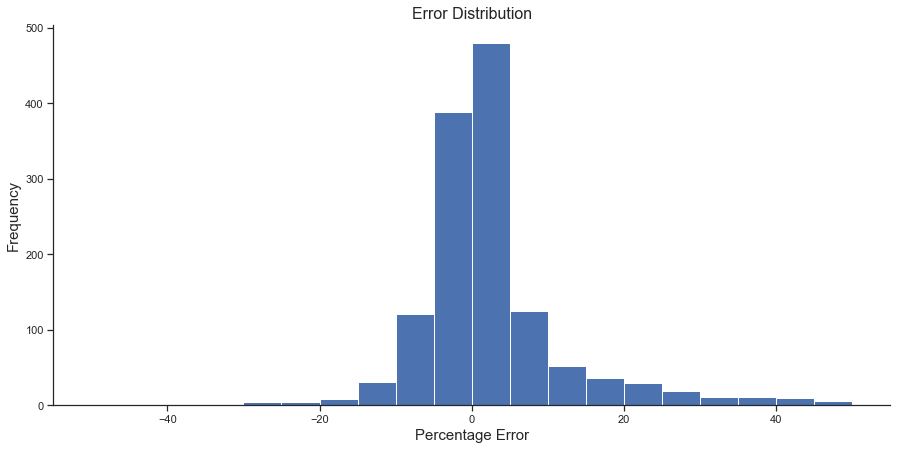

In [19]:
ev = e.get_error_percentages(valpreds, operator[0], model)
e.plot_error_distribution(ev)

Investigating performance by time of day shows that the larger deviations occur in the mornings and evenings, when generation is significantly lower and accuracy much less of a concern. The model performs well during periods of high generation

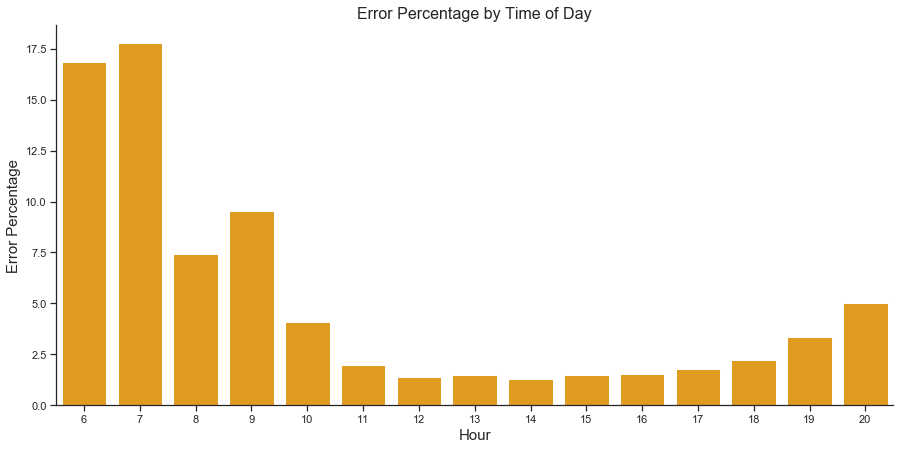

In [20]:
ev['hour'] = ev.index.hour
ev['abs_error_perc'] = np.abs(ev['error_perc'])
dev = ev.groupby('hour')['abs_error_perc'].median().reset_index()

sns.barplot(x='hour', y='abs_error_perc', data=dev, color='orange')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Error Percentage by Time of Day')
plt.xlabel('Hour')
plt.ylabel('Error Percentage')
sns.despine()

Model performance in June and July tracks actuals closely. Predictions were thrown off a bit by a strange spell of weather in early June - but this is a good sign, indicating that the model isn't overfitting. The latter half of June through July shows the model performing well, adjusting to generation dips and slightly underpredicting abrupt peaks. 

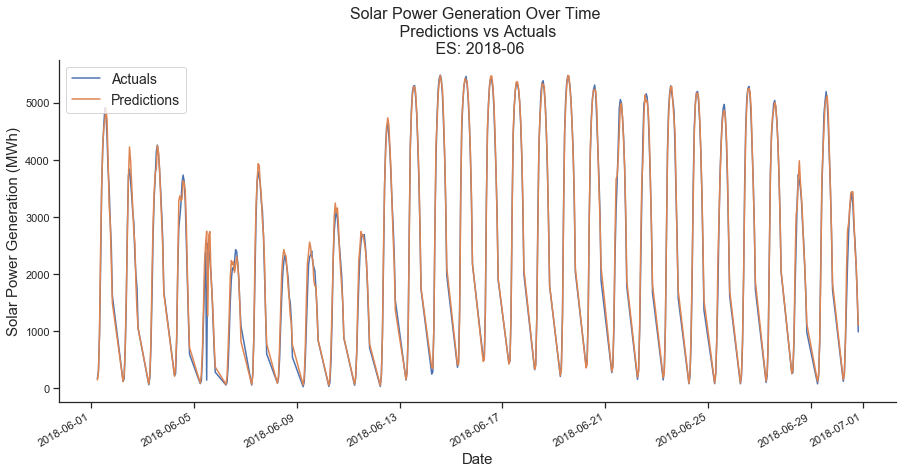

In [21]:
e.plot_results(ev, model, '2018-06-01', '2018-06-30')

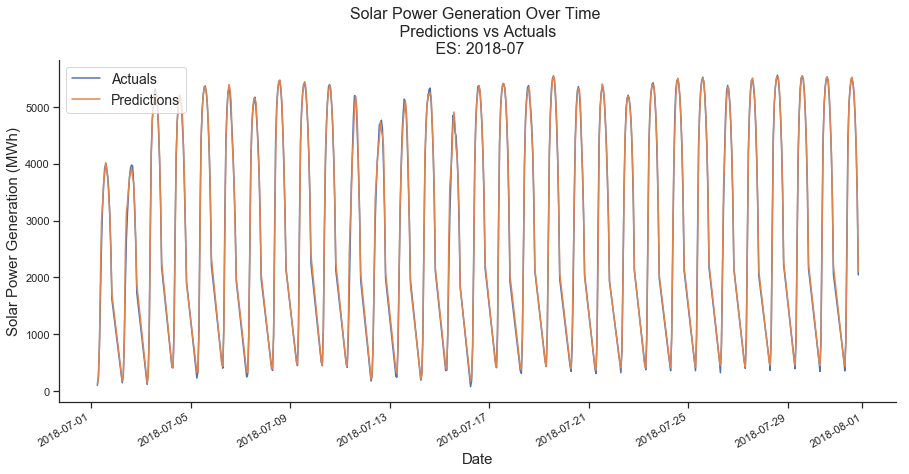

In [22]:
e.plot_results(ev, model, '2018-07-01', '2018-07-31')

##### TenneT

In [23]:
operator = ['DE(TenneT GER)']
print('MDAPE')
e.evaluate_predictions(e.mdape, valpreds, operator, models)

MDAPE


,operator,rf,xgb,nn,knn,e_rxn,e_rxnk
0,DE(TenneT GER),3.26,3.79,5.08,17.78,3.35,5.63


In [24]:
print('RMSE')
e.evaluate_predictions(e.rmse, valpreds, operator, models)

RMSE


,operator,rf,xgb,nn,knn,e_rxn,e_rxnk
0,DE(TenneT GER),211.9,251.18,334.66,1135.12,218.8,371.79


**Random Forests perform best for TenneT with a MDAPE of 3.3% and a RMSE of 212MWh**

The error distribution is similar, but with a tendency to underpredict. Given that it's easier to curtail generation than to bring additional plants online, this is the directionality one would hope for.

count    5520.000000
mean        0.054991
std        11.219755
min       -47.758865
25%        -3.944003
50%        -1.047084
75%         2.213065
max       291.333333
Name: error_perc, dtype: float64


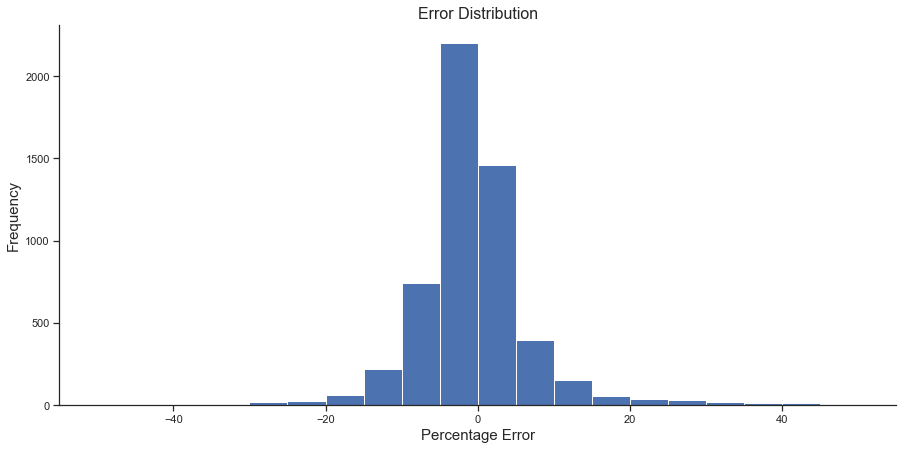

In [25]:
model = 'rf'
ev = e.get_error_percentages(valpreds, operator[0], model)
e.plot_error_distribution(ev)

Predictions track generation very well

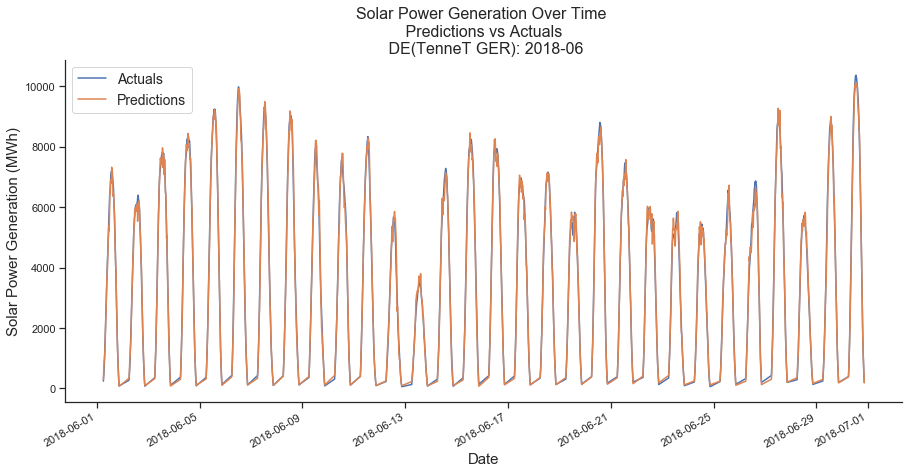

In [26]:
e.plot_results(ev, model, '2018-06-01', '2018-06-30')

Zooming in, we see generation predictions are a bit more jagged than actuals. Actual generation is likely smoothed over before being deployed to the grid. This is difficult for us to predict without knowledge of the operators' deployment mechnanisms, so the error is a little higher than it would otherwise be.

A rolling average could be employed to smooth predictions, but since the point of this exercise is to help operators make decisions based on actual volatile generation, applying an algorithm to mimic decisions taken after the fact would defeat the purpose.

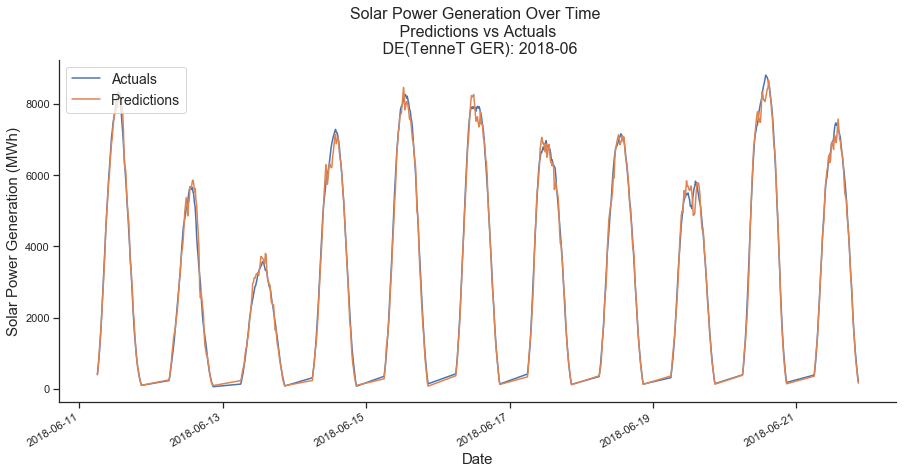

In [27]:
e.plot_results(ev, model, '2018-06-11', '2018-06-21')

##### All Operators

Performance across operators is line with what we observed above

In [28]:
print('RMSE')
aresults = e.evaluate_predictions(e.rmse, valpreds, operators, models)
aresults

RMSE


,operator,rf,xgb,nn,knn,e_rxn,e_rxnk
0,ES,163.43,167.25,223.60,505.71,161.88,196.29
1,IT,270.40,290.84,487.74,872.30,279.10,344.96
2,FR,171.02,176.90,206.64,560.04,148.06,200.31
3,DE(Amprion),145.78,171.25,255.12,1357.31,146.24,371.31
4,DE(TenneT GER),211.90,251.18,334.66,1135.12,218.80,371.79
5,DE(TransnetBW),96.51,113.81,158.03,648.08,103.00,193.53
6,DE(50Hertz),242.41,256.26,218.40,716.22,209.74,277.26


In [29]:
print('MDAPE')
presults = e.evaluate_predictions(e.mdape, valpreds, operators, models)
presults

MDAPE


,operator,rf,xgb,nn,knn,e_rxn,e_rxnk
0,ES,3.26,3.46,4.86,11.92,3.05,4.17
1,IT,4.09,4.71,8.09,12.31,4.50,5.39
2,FR,3.66,4.05,6.29,15.10,3.22,4.87
3,DE(Amprion),3.42,4.15,6.95,38.59,3.76,10.10
4,DE(TenneT GER),3.26,3.79,5.08,17.78,3.35,5.63
5,DE(TransnetBW),4.20,5.32,7.50,28.06,4.52,8.61
6,DE(50Hertz),4.68,4.88,4.25,13.85,4.09,5.62


- MDAPE ranges from 3-5% across the board
- Random Forests seem to do quite well, but the ensemble of Random Forests, XGB, and Neural Nets performs better for Spain, France, and 50Hertz
- KNN can sometimes help capture patterns in the data that other models miss and help with predicting outliers. That doesn't seem to be the case here

**This leaves us with the following validation results**

In [30]:
models_h = {'ES':'e_rxn', 'IT':'rf', 'FR':'e_rxn', 
            'DE(Amprion)':'rf', 'DE(TenneT GER)':'rf', 'DE(TransnetBW)':'rf', 
            'DE(50Hertz)':'e_rxn', }

In [31]:
print('RMSE')
val_results = {key:aresults[aresults['operator'] == key][value].values[0] for (key,value) in models_h.items()}
val_results

RMSE


{'ES': 161.88,
 'IT': 270.4,
 'FR': 148.06,
 'DE(Amprion)': 145.78,
 'DE(TenneT GER)': 211.9,
 'DE(TransnetBW)': 96.51,
 'DE(50Hertz)': 209.74}

In [32]:
print('MDAPE')
val_results = {key:presults[presults['operator'] == key][value].values[0] for (key,value) in models_h.items()}
val_results

MDAPE


{'ES': 3.05,
 'IT': 4.09,
 'FR': 3.22,
 'DE(Amprion)': 3.42,
 'DE(TenneT GER)': 3.26,
 'DE(TransnetBW)': 4.2,
 'DE(50Hertz)': 4.09}

### Testing

Train on the entire dataset up to the end of the validation period

#### Set Test Period

In [33]:
test_periods = ['2018-08-01']
test_length = 61

#### Generate  Predictions

In [34]:
## Uncomment to run

# pg = m.PredictionGenerator(data, operators, features, params, train_start, test_periods, test_length)
# pg.run()

# testpreds = pg.predictions
# testpreds.to_csv('results/testpreds_h.csv', index=False)

In [35]:
testpreds = pd.read_csv('results/testpreds_h.csv')
print(testpreds.shape)
testpreds.head()

(16042, 7)


,int_start,knn,nn,operator,rf,solar,xgb
0,2018-08-01 06:00:00,545.0,494.896942,ES,526.08,450.0,547.364197
1,2018-08-01 07:00:00,355.0,328.669769,ES,341.78,306.0,323.714142
2,2018-08-01 08:00:00,939.0,835.026733,ES,774.66,858.0,792.647217
3,2018-08-01 09:00:00,2665.0,2370.905273,ES,2205.94,2356.0,2246.916748
4,2018-08-01 10:00:00,4333.0,4210.340332,ES,3851.00,3843.0,3851.469971


#### Ensemble

In [36]:
testpreds = e.ensemble(testpreds)
#testpreds.head()

#### Evaluate

The models test well across August and September for both Spain and TenneT

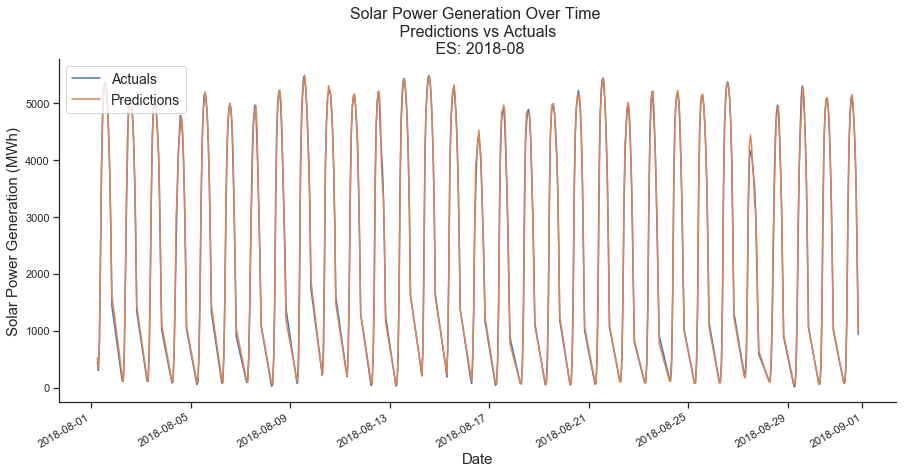

In [37]:
ev = e.get_error_percentages(testpreds, 'ES', 'e_rxn')
e.plot_results(ev, model, '2018-08-01', '2018-08-31')

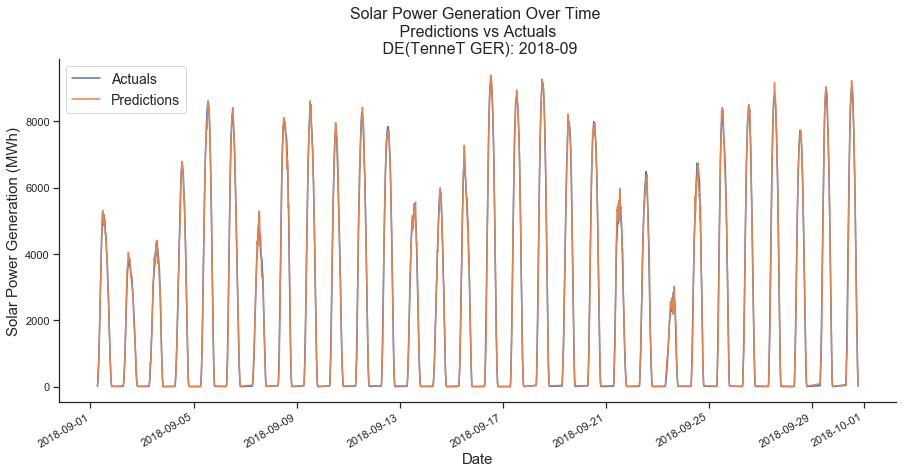

In [38]:
ev = e.get_error_percentages(testpreds, 'DE(TenneT GER)', 'rf')
e.plot_results(ev, model, '2018-09-01', '2018-09-30')

Validation results hold across operators, although the error is slightly higher. As shown above, generation in September is more variable than other months, so this is to be expected.

In [39]:
print('RMSE')
aresults = e.evaluate_predictions(e.rmse, testpreds, operators, models)
test_results = {key:aresults[aresults['operator'] == key][value].values[0] for (key,value) in models_h.items()}
test_results

RMSE


{'ES': 168.49,
 'IT': 278.14,
 'FR': 130.06,
 'DE(Amprion)': 146.98,
 'DE(TenneT GER)': 190.84,
 'DE(TransnetBW)': 89.71,
 'DE(50Hertz)': 238.68}

In [40]:
print('MDAPE')
presults = e.evaluate_predictions(e.mdape, testpreds, operators, models)
test_results = {key:presults[presults['operator'] == key][value].values[0] for (key,value) in models_h.items()}
test_results

MDAPE


{'ES': 3.85,
 'IT': 4.56,
 'FR': 4.27,
 'DE(Amprion)': 4.22,
 'DE(TenneT GER)': 3.49,
 'DE(TransnetBW)': 4.58,
 'DE(50Hertz)': 5.52}

## Day-ahead Forecasts

Day-ahead forecasts are normally published the evening before. In the absence of clear guidelines on when these are generated by different operators, we'll assume a conservative lag of 24 hours.

While the parameters and features change, the approach remains the same. 

### Set Paramaters

In [41]:
features = {'base': 'year|month|month_year|week|hour|minute', 
            'trailing': 'day_bef|multiday',
            'capacity': 'solcap',
            'daily': 'sun|_temperaturehigh|_temperaturelow',
            'hourly': 'icon|cloudcover|precipprobability|temperature|visibility|uvindex'}

train_start = '2016-01-01'

lrates = {'ES':1e-3, 'IT':1e-3, 'FR':1e-3, 'DE(TenneT GER)':1e-3,
          'DE(TransnetBW)':1e-3, 'DE(50Hertz)':1e-3, 'DE(Amprion)':1e-3}


params = {'rf' : {'n_estimators':50, 'max_features':0.8},
          'xgb': {'n_estimators':50, 'learning_rate':0.1, 'max_depth':10, 'subsample':0.8, 
                  'colsample_bytree': 0.8,'early_stopping_rounds':10},
          'knn': {'k':5, 'space':'l2'},
          'nn': {'lr':lrates, 'emb_drop':0.02, 'szs':[1000,500], 'drops':[0.001,0.01], 'use_bn':True}}

### Validation

#### France, Spain, and Italy

In [42]:
operators = ['ES','IT', 'FR']

##### Set Validation Period

In [43]:
val_periods = ['2018-05-01']
val_length = 92

##### Generate Predictions

In [44]:
## Uncomment to run

# pg = m.PredictionGenerator(data, operators, features, params, train_start, val_periods, val_length)
# pg.run()

# valpreds = pg.predictions
# valpreds.to_csv('results/valpreds_d_o.csv', index=False)

In [45]:
valpreds = pd.read_csv('results/valpreds_d_o.csv')
print(valpreds.shape)
valpreds.head()

(4137, 9)


,int_start,knn,nn,operator,rf,solar,xgb,e_rxn,e_rxnk
0,2018-05-01 06:00:00,111.0,166.415024,ES,136.68,11.0,156.538971,153.211332,142.658499
1,2018-05-01 07:00:00,31.0,231.176941,ES,172.44,69.0,175.384354,193.000432,152.500324
2,2018-05-01 08:00:00,753.0,1265.625854,ES,714.62,668.0,852.147278,944.131044,896.348283
3,2018-05-01 09:00:00,1497.0,2560.046387,ES,1945.86,1765.0,2225.535156,2243.813848,2057.110386
4,2018-05-01 10:00:00,2159.0,3693.556152,ES,3265.32,2895.0,2839.783203,3266.219785,2989.414839


##### Ensemble

In [46]:
valpreds = e.ensemble(valpreds)

##### Evaluate

In [47]:
models = ['rf','xgb','nn','knn','e_rxn','e_rxnk']

In [48]:
print('RMSE')
aresults = e.evaluate_predictions(e.rmse, valpreds, operators, models)
aresults

RMSE


,operator,rf,xgb,nn,knn,e_rxn,e_rxnk
0,ES,597.08,685.24,858.67,786.50,636.21,628.91
1,IT,752.91,698.00,867.49,1118.39,692.34,730.95
2,FR,353.04,388.76,329.32,760.48,323.18,347.99


MDAPE ranges from 8-13%

In [49]:
print('MDAPE')
presults = e.evaluate_predictions(e.mdape, valpreds, operators, models)
presults

MDAPE


,operator,rf,xgb,nn,knn,e_rxn,e_rxnk
0,ES,12.69,17.23,18.42,17.84,13.61,13.75
1,IT,9.34,9.45,12.65,16.21,8.58,10.23
2,FR,8.08,9.39,8.66,20.51,7.50,9.18


In [50]:
models_d_o = {'ES':'rf', 'IT':'e_rxn', 'FR':'e_rxn'}

In [51]:
val_results = {key:presults[presults['operator'] == key][value].values[0] for (key,value) in models_d_o.items()}
val_results

{'ES': 12.69, 'IT': 8.58, 'FR': 7.5}

While an error of below 7%-12% for day-ahead forecasts is objectively acceptable, looking at model performance more closely shows some clear limitations. Unlike intra-day forecasts, the models struggle to levelset appropriately, particularly with abrupt peaks and dips

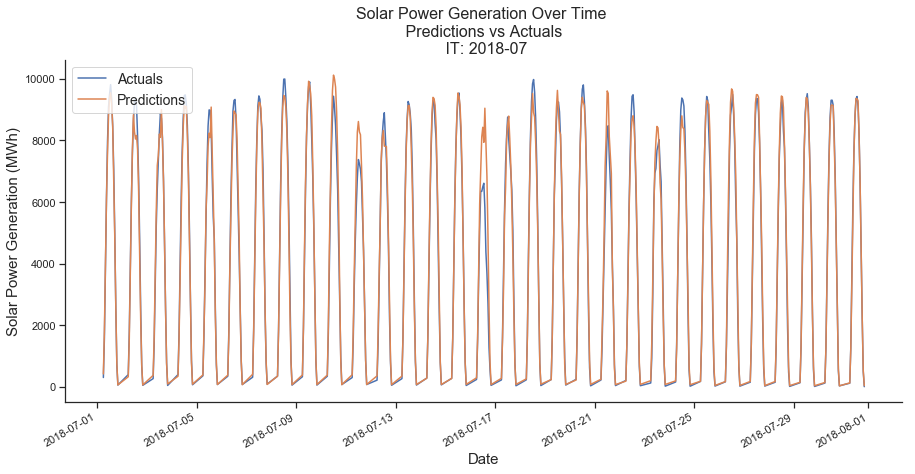

In [52]:
operator = 'IT'
model = 'e_rxn'
ev = e.get_error_percentages(valpreds, operator, model)
e.plot_results(ev, model, '2018-07-01', '2018-07-31')

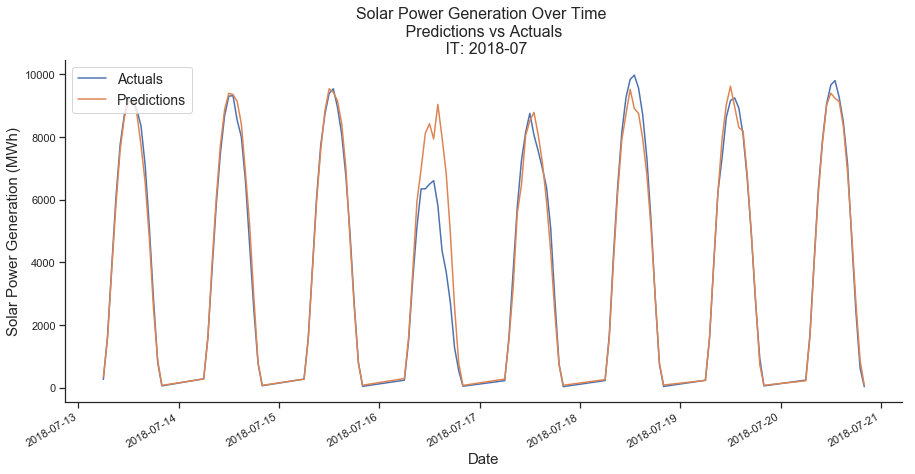

In [53]:
e.plot_results(ev, model, '2018-07-13', '2018-07-20')

We investigate this further by looking at the significant drop in generation in Italy on the 16th of July

In [54]:
clouds = '^h.*.cloudCover$'
temp = '^h.*._temperature$'
precip = '^d.*.precipProbability$'
uv = '^h.*.uvIndex$'

Interestingly, the data shows a spike in cloud cover in the morning, which the model adjusts for. Generation however, remains low for the rest of the day. It's possible that generation is actively curtailed on cloudy days, information that we don't currently have access to

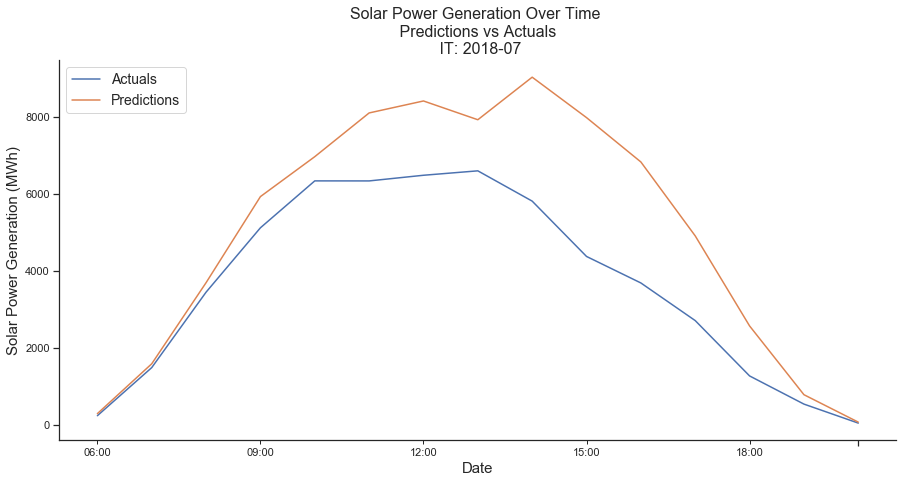

In [56]:
e.plot_results(ev, model, '2018-07-16', '2018-07-16')

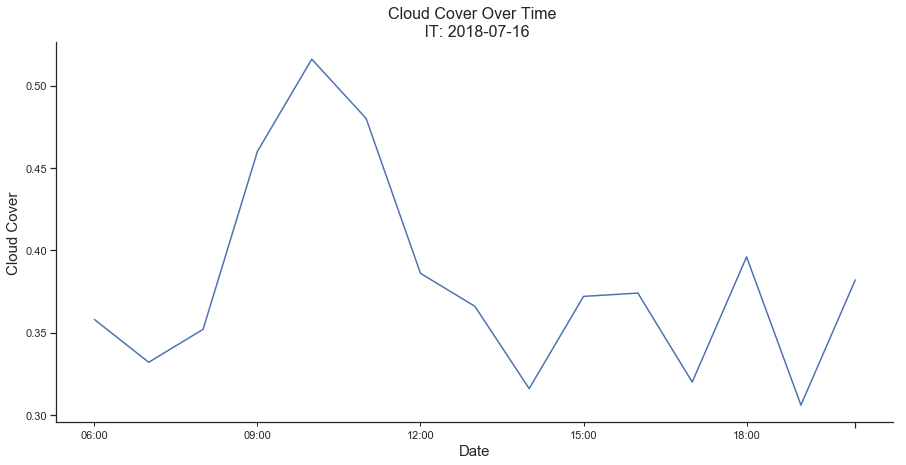

In [66]:
e.get_means(data, 'IT', '2018-07-16', '2018-07-16', clouds).plot()
plt.ticklabel_format(style='plain', axis='y')
plt.title('Cloud Cover Over Time \n IT: 2018-07-16')
plt.xlabel('Date')
plt.ylabel('Cloud Cover')
sns.despine()

Conversely, June 20th in France saw an abrupt rise in generation, caused by sudden, short-lived declines in cloud cover.

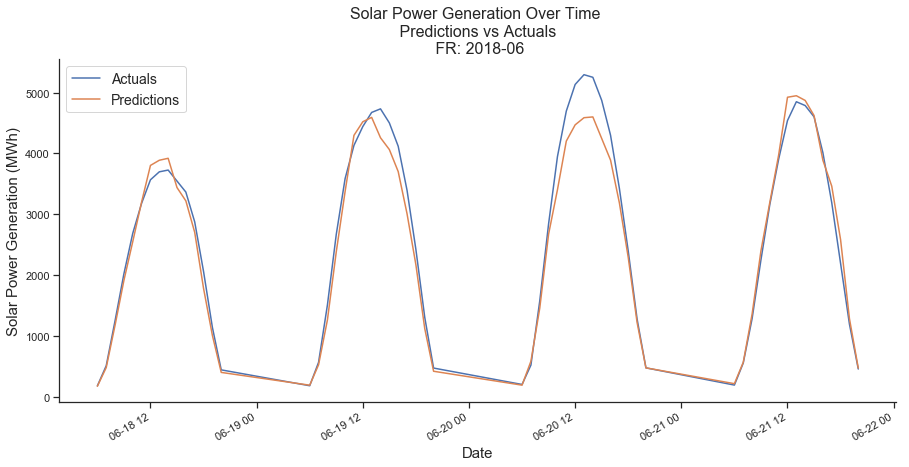

In [62]:
operator = 'FR'
model = 'e_rxn'
ev = e.get_error_percentages(valpreds, operator, model)
e.plot_results(ev, model, '2018-06-18', '2018-06-21')

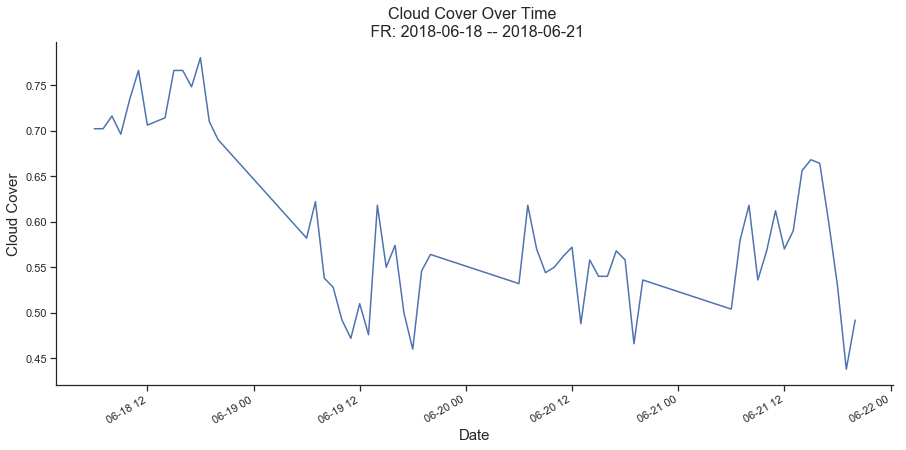

In [69]:
e.get_means(data, 'FR', '2018-06-18', '2018-06-21', clouds).plot()
plt.ticklabel_format(style='plain', axis='y')
plt.title('Cloud Cover Over Time \n FR: 2018-06-18 -- 2018-06-21')
plt.xlabel('Date')
plt.ylabel('Cloud Cover')
sns.despine()

It's possible that the distribution of coordinates we've chosen doesn't accurately represent the actual geographical generation profile. Cloud cover for instance, declines rapidly for about an hour around noon, climbs back up for the afternoon and falls again in the evening. The cloud cover remaining low at locations generating the majority of solar power would explain the discrepancy between actuals and predictions.

Aligning our coordinates with actual generation should significantly improve model performance.

#### German Operators

In [60]:
operators = ['DE(Amprion)','DE(TenneT GER)','DE(TransnetBW)','DE(50Hertz)']

##### Set Validation Period

There's a steady increase in installed capacity and generation over time across Germany, but capacity data is only available on an annual basis. Since we're relying quite a bit on trees, the models have to be retrained more frequently than would otherwise be necessary

In [61]:
val_periods = ['2018-05-01', '2018-06-01', '2018-07-01']
val_length = 30

##### Generate Predictions

In [62]:
## Uncomment to run

# pg = m.PredictionGenerator(data, operators, features, params, train_start, val_periods, val_length)
# pg.run()

# valpreds = pg.predictions
# valpreds.to_csv('results/valpreds_d_g.csv', index=False)

In [63]:
valpreds = pd.read_csv('results/valpreds_d_g.csv')
print(valpreds.shape)
valpreds.head()

(21578, 7)


,int_start,knn,nn,operator,rf,solar,xgb
0,2018-05-01 06:15:00,84.0,6.543253,DE(Amprion),47.08,6.0,34.325920
1,2018-05-01 06:30:00,84.0,28.821796,DE(Amprion),128.66,25.0,89.122543
2,2018-05-01 06:45:00,84.0,72.269226,DE(Amprion),239.18,61.0,177.520935
3,2018-05-01 07:00:00,158.0,152.670822,DE(Amprion),306.18,117.0,268.894043
4,2018-05-01 07:15:00,1375.0,267.011230,DE(Amprion),325.26,190.0,318.253113


##### Ensemble

In [64]:
valpreds = e.ensemble(valpreds)

##### Evaluate

In [65]:
print('RMSE')
results = e.evaluate_predictions(e.rmse, valpreds, operators, models)
results

RMSE


,operator,rf,xgb,nn,knn,e_rxn,e_rxnk
0,DE(Amprion),469.13,469.93,598.74,974.82,468.68,535.64
1,DE(TenneT GER),911.65,906.43,845.24,1449.54,826.84,872.20
2,DE(TransnetBW),289.10,300.44,383.29,515.50,296.33,315.85
3,DE(50Hertz),715.16,715.96,707.88,1163.47,648.33,699.10


MDAPE for the German operators hovers around the 10-12% mark

In [66]:
print('MDAPE')
results = e.evaluate_predictions(e.mdape, valpreds, operators, models)
results

MDAPE


,operator,rf,xgb,nn,knn,e_rxn,e_rxnk
0,DE(Amprion),9.52,10.07,13.33,20.55,9.98,11.53
1,DE(TenneT GER),11.46,11.64,12.49,21.54,10.82,12.27
2,DE(TransnetBW),10.16,10.64,14.20,21.40,10.08,11.37
3,DE(50Hertz),11.97,12.04,12.72,20.34,11.15,12.57


In [67]:
models_d_g = {'DE(Amprion)':'e_rxn', 'DE(TenneT GER)':'e_rxn', 'DE(TransnetBW)':'e_rxn', 'DE(50Hertz)':'e_rxn'}

In [68]:
val_results = {key:results[results['operator'] == key][value].values[0] for (key,value) in models_d_g.items()}
val_results

{'DE(Amprion)': 9.98,
 'DE(TenneT GER)': 10.82,
 'DE(TransnetBW)': 10.08,
 'DE(50Hertz)': 11.15}

We see a similar limitation with regard to peaks and troughs

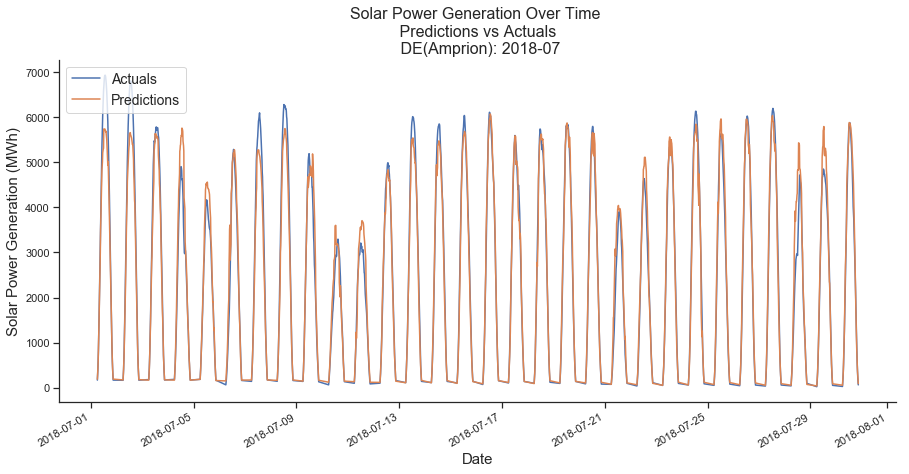

In [69]:
operator = 'DE(Amprion)'
model = 'e_rxn'
ev = e.get_error_percentages(valpreds, operator, model)
e.plot_results(ev, model, '2018-07-01', '2018-07-31')

### Testing

#### France, Spain, and Italy

In [70]:
operators = ['ES','IT', 'FR']

##### Set Test Period

In [71]:
test_periods = ['2018-08-01']
test_length = 61

##### Generate Predictions

In [72]:
## Uncomment to run

# pg = m.PredictionGenerator(data, operators, features, params, train_start, test_periods, test_length)
# pg.run()

# testpreds = pg.predictions
# testpreds.to_csv('results/testpreds_d_o.csv', index=False)

In [73]:
testpreds = pd.read_csv('results/testpreds_d_o.csv')
print(testpreds.shape)
testpreds.head()

(2663, 7)


,int_start,knn,nn,operator,rf,solar,xgb
0,2018-08-01 06:00:00,545.0,485.863342,ES,542.70,450.0,555.151794
1,2018-08-01 07:00:00,355.0,346.383850,ES,328.84,306.0,359.788513
2,2018-08-01 08:00:00,939.0,1074.243042,ES,914.80,858.0,859.443665
3,2018-08-01 09:00:00,2665.0,2661.730225,ES,2491.10,2356.0,2665.590820
4,2018-08-01 10:00:00,4122.0,4106.924805,ES,3935.90,3843.0,4282.730957


##### Ensemble

In [74]:
testpreds = e.ensemble(testpreds)

##### Evaluate

Validation results hold, and model strengths and weaknesses persist

In [75]:
print('RMSE')
results = e.evaluate_predictions(e.rmse, testpreds, operators, models)
results

RMSE


,operator,rf,xgb,nn,knn,e_rxn,e_rxnk
0,ES,484.35,506.48,1159.02,678.96,580.70,556.43
1,IT,646.14,640.63,1045.22,1043.24,698.00,701.87
2,FR,392.46,379.73,334.46,558.09,326.98,358.34


In [76]:
test_results = {key:results[results['operator'] == key][value].values[0] for (key,value) in models_d_o.items()}
test_results

{'ES': 484.35, 'IT': 698.0, 'FR': 326.98}

In [77]:
print('MDAPE')
results = e.evaluate_predictions(e.mdape, testpreds, operators, models)
results

MDAPE


,operator,rf,xgb,nn,knn,e_rxn,e_rxnk
0,ES,9.95,11.20,24.17,18.17,12.95,13.56
1,IT,8.94,8.70,12.21,17.10,8.67,10.21
2,FR,9.75,10.33,8.69,16.12,8.82,9.90


In [78]:
test_results = {key:results[results['operator'] == key][value].values[0] for (key,value) in models_d_o.items()}
test_results

{'ES': 9.95, 'IT': 8.67, 'FR': 8.82}

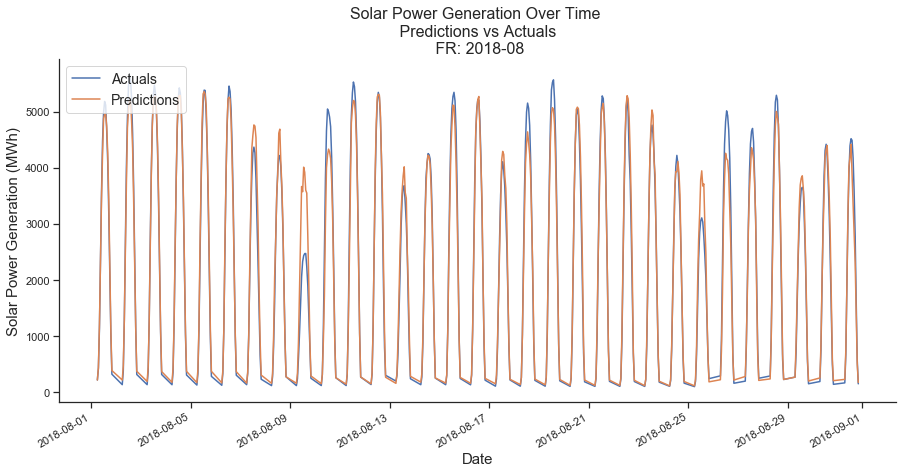

In [79]:
operator = 'FR'
model = 'e_rxn'
ev = e.get_error_percentages(testpreds, operator, model)
e.plot_results(ev, model, '2018-08-01', '2018-08-31')

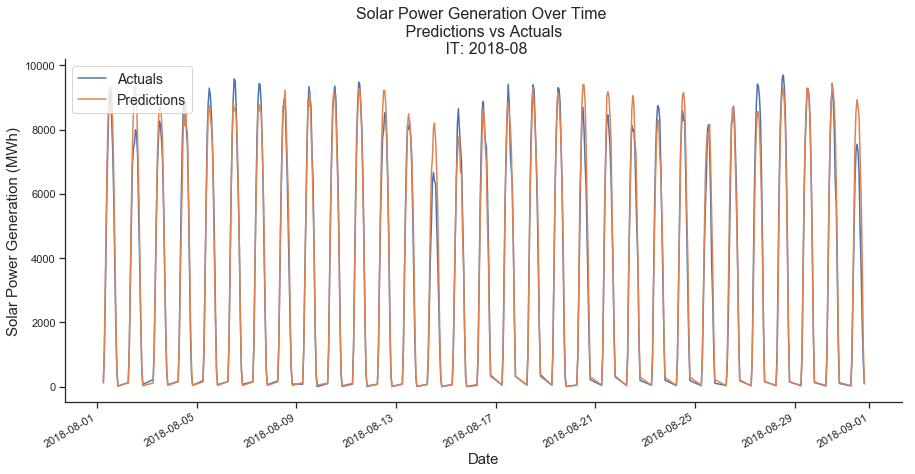

In [80]:
operator = 'IT'
model = 'e_rxn'
ev = e.get_error_percentages(testpreds, operator, model)
e.plot_results(ev, model, '2018-08-01', '2018-08-31')

#### German Operators

In [81]:
operators = ['DE(Amprion)','DE(TenneT GER)','DE(TransnetBW)','DE(50Hertz)']

##### Set Test Period

In [82]:
test_periods = ['2018-08-01', '2018-09-01']
test_length = 30

##### Generate Predictions

In [83]:
## Uncomment to run

# pg = m.PredictionGenerator(data, operators, features, params, train_start, test_periods, test_length)
# pg.run()

# testpreds = pg.predictions
# testpreds.to_csv('results/testpreds_d_g.csv', index=False)

In [84]:
testpreds = pd.read_csv('results/testpreds_d_g.csv')
print(testpreds.shape)
testpreds.head()

(13157, 7)


,int_start,knn,nn,operator,rf,solar,xgb
0,2018-08-01 06:00:00,41.0,14.609902,DE(Amprion),30.18,11.0,31.210098
1,2018-08-01 06:15:00,109.0,67.586258,DE(Amprion),97.22,77.0,101.718391
2,2018-08-01 06:30:00,215.0,171.042892,DE(Amprion),214.70,169.0,197.707733
3,2018-08-01 06:45:00,342.0,314.961365,DE(Amprion),333.66,288.0,299.267426
4,2018-08-01 07:00:00,511.0,477.626221,DE(Amprion),476.88,436.0,431.481628


##### Ensemble

In [85]:
testpreds = e.ensemble(testpreds)

##### Evaluate

Performance is a little worse due to volatility in September

In [86]:
print('RMSE')
results = e.evaluate_predictions(e.rmse, testpreds, operators, models)
results

RMSE


,operator,rf,xgb,nn,knn,e_rxn,e_rxnk
0,DE(Amprion),489.07,488.00,473.38,920.10,431.86,492.65
1,DE(TenneT GER),896.52,846.00,1080.66,1279.89,850.13,878.66
2,DE(TransnetBW),335.69,341.37,351.58,497.47,293.05,304.57
3,DE(50Hertz),734.95,757.43,1403.20,1262.61,827.41,869.60


In [87]:
test_results = {key:results[results['operator'] == key][value].values[0] for (key,value) in models_d_g.items()}
test_results

{'DE(Amprion)': 431.86,
 'DE(TenneT GER)': 850.13,
 'DE(TransnetBW)': 293.05,
 'DE(50Hertz)': 827.41}

In [88]:
print('MDAPE')
results = e.evaluate_predictions(e.mdape, testpreds, operators, models)
results

MDAPE


,operator,rf,xgb,nn,knn,e_rxn,e_rxnk
0,DE(Amprion),12.16,12.09,12.62,25.68,11.52,13.94
1,DE(TenneT GER),13.52,12.68,16.42,23.71,12.88,14.39
2,DE(TransnetBW),12.42,12.78,16.86,25.03,12.26,13.56
3,DE(50Hertz),15.45,14.71,18.94,31.04,15.70,18.00


In [89]:
test_results = {key:results[results['operator'] == key][value].values[0] for (key,value) in models_d_g.items()}
test_results

{'DE(Amprion)': 11.52,
 'DE(TenneT GER)': 12.88,
 'DE(TransnetBW)': 12.26,
 'DE(50Hertz)': 15.7}

The same model limitations apply

## Conclusion

The approach performs quite well for intra-day forecasts, with an MDAPE ranging from 3-5% across operators. This is encouraging, given that the purpose of this exercise was to develop a quick, lightweight, accurate approach to near-term forecasting.

We also tested the approach on day-ahead forecasts. While the error ranges from a broadly acceptable 10-12%, the models struggle to predict abrupt peaks and dips. We're not privy to decisions operators make regarding curtailment, or to the actual geographical generation profile. This isn't a problem for intra-day forecasts since the models are able to levelset using trailing features, but building these aspects into day-ahead modeling should bring the error down. We can also try building separate models for days when the weather is expected to be significantly different from the norm.